/var/folders/3v/t7p60tvs5773q0xm_4_bb2tr0000gn/T/ipykernel_3593/104465437.py:95: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lf_power = np.trapz(psd[lf_mask], frequencies[lf_mask])
/var/folders/3v/t7p60tvs5773q0xm_4_bb2tr0000gn/T/ipykernel_3593/104465437.py:96: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hf_power = np.trapz(psd[hf_mask], frequencies[hf_mask])


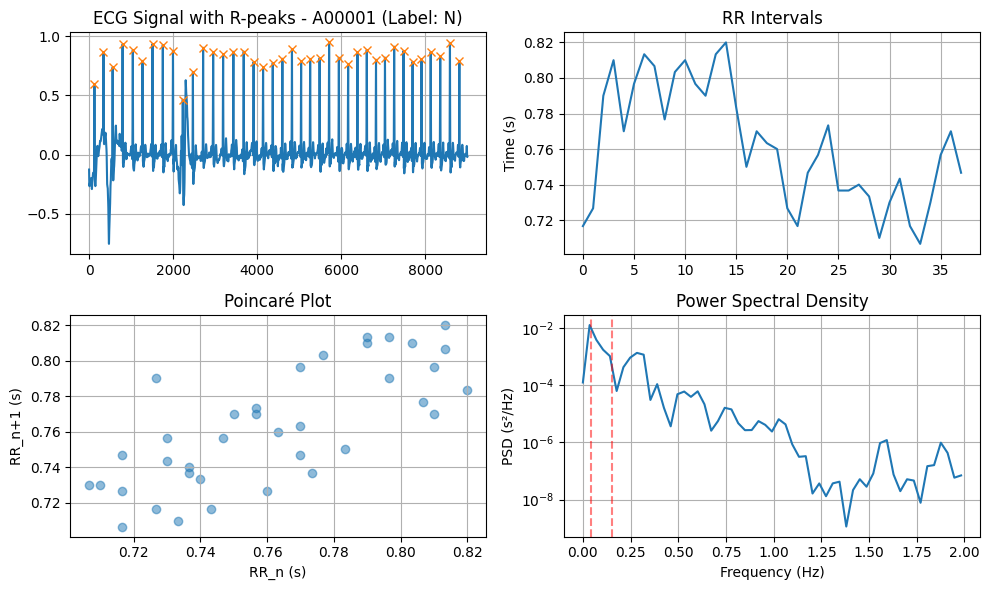

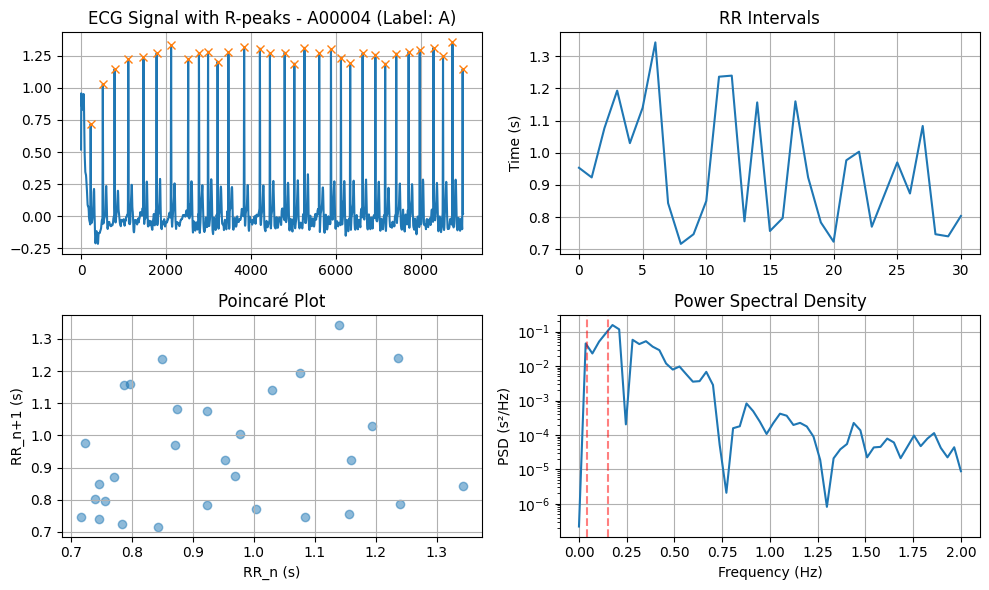

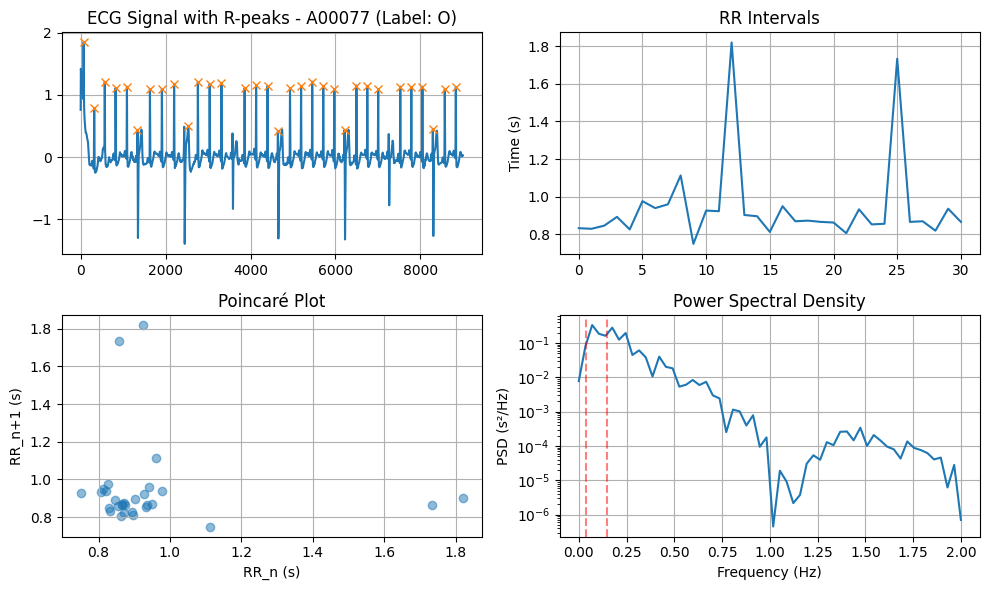

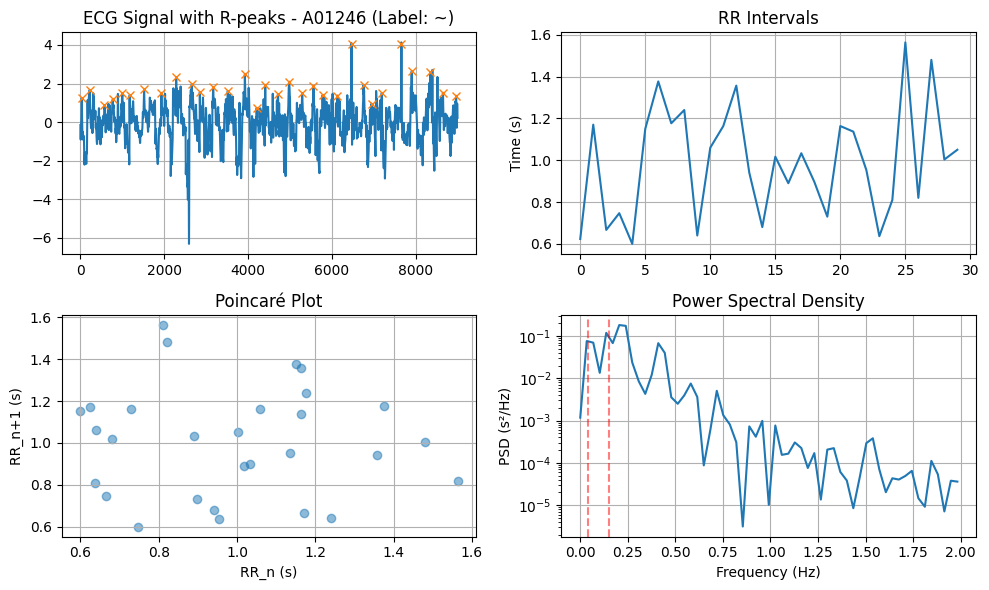


HRV Analysis Results:
  record_id label    mean_hr     std_hr        sdnn       rmssd  nn50  \
0    A00001     N  78.774617   3.430366   33.243299   23.436067     1   
1    A00004     A  63.662293  11.735335  178.025748  228.815792    24   
2    A00077     O  63.655031   9.678973  228.701665  339.640333    18   
3    A01246     ~  60.456785  17.812807  261.151203  377.720528    27   

       pnn50         tinn  lf_power  hf_power  lf_hf_ratio  total_power  \
0   2.631579   113.333333  0.000145  0.000138     1.047128     0.000283   
1  77.419355   626.666667  0.003784  0.012895     0.293459     0.016679   
2  58.064516  1070.000000  0.015261  0.021463     0.711048     0.036723   
3  90.000000   963.333333  0.003695  0.014822     0.249308     0.018518   

          sd1         sd2  sd_ratio  
0   16.561881   33.243299  0.498202  
1  161.758565  178.025748  0.908625  
2  240.160697  228.701665  1.050105  
3  266.886057  261.151203  1.021960  


In [1]:
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Find R-peaks using a simple threshold method
# Note: For production, you might want to use more sophisticated methods like Pan-Tompkins
from scipy.signal import find_peaks, butter, filtfilt

# Set the directory where your PhysioNet data is stored
data_path = "data/training2017"

# Read the reference file (contains labels)
labels_df = pd.read_csv(f'{data_path}/REFERENCE.csv', header=None, names=['record_name', 'label'])

# Bandpass filter for preprocessing
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=300, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data)

# Compute for Heart Rate Variability
def analyze_hrv(record_name, data_path, labels_df, plot=False):
    """
    Compute Heart Rate Variability and other advanced ECG metrics
    """
    # Read the record
    record = wfdb.rdrecord(f'{data_path}/{record_name}')
    signals = record.p_signal.flatten()
    label = labels_df[labels_df.record_name == record_name].label.values[0]
    
    # Normalize signal
    # normalized_signal = (signals - np.mean(signals)) / np.std(signals)
    filtered_signals = bandpass_filter(signals, lowcut=0.5, highcut=40.0, fs=record.fs)

    # Find R-peaks
    r_peaks, _ = find_peaks(filtered_signals, prominence=0.6, distance=0.6*300)  # Adjust these parameters as needed
    
    # Validate that we have enough R-peaks
    if len(r_peaks) < 2:
        print(f'Insufficient R-peaks detected for record {record_name}')
        return None
    
    # Calculate RR intervals (in seconds)
    sampling_rate = 300  # Hz (typical for this dataset)
    rr_intervals = np.diff(r_peaks) / sampling_rate

    # Validate RR intervals
    if len(rr_intervals) == 0 or np.mean(rr_intervals) == 0:    
        print(f'Invalid RR intervals for record {record_name}')
        return None
    
    # HRV Time Domain Metrics
    hrv_metrics = {
        'record_id': record_name,
        'label': label,
        
        # Basic HR metrics
        'mean_hr': 60 / np.mean(rr_intervals),  # Mean heart rate in BPM
        'std_hr': np.std(60 / rr_intervals),    # Standard deviation of heart rate
        
        # Time domain HRV metrics
        'sdnn': np.std(rr_intervals) * 1000,    # Standard deviation of NN intervals (ms)
        'rmssd': np.sqrt(np.mean(np.diff(rr_intervals) ** 2)) * 1000,  # Root mean square of successive differences (ms)
        'nn50': sum(np.abs(np.diff(rr_intervals)) > 0.05),  # Number of pairs of successive intervals differing by > 50ms
        'pnn50': sum(np.abs(np.diff(rr_intervals)) > 0.05) / len(rr_intervals) * 100,  # Percentage of NN50
        
        # Geometric metrics
        'tinn': np.ptp(rr_intervals) * 1000,  # Triangular interpolation of NN interval histogram (ms)
    }
    
    # Frequency Domain Analysis
    if len(rr_intervals) > 4:  # Need minimum number of intervals
        from scipy import signal
        
        # Interpolate RR intervals to get evenly sampled signal
        rr_x = np.cumsum(rr_intervals)
        rr_x -= rr_x[0]  # Start at 0
        fs = 4.0  # Hz
        rr_x_interp = np.arange(rr_x[0], rr_x[-1], 1.0/fs)
        rr_y_interp = np.interp(rr_x_interp, rr_x, rr_intervals)
        
        # Calculate Power Spectral Density
        frequencies, psd = signal.welch(rr_y_interp, fs=fs, nperseg=len(rr_y_interp))
        
        # Frequency bands
        vlf_mask = (frequencies >= 0.003) & (frequencies < 0.04)
        lf_mask = (frequencies >= 0.04) & (frequencies < 0.15)
        hf_mask = (frequencies >= 0.15) & (frequencies < 0.4)
        
        # Power calculations
        lf_power = np.trapz(psd[lf_mask], frequencies[lf_mask])
        hf_power = np.trapz(psd[hf_mask], frequencies[hf_mask])
        lf_hf_ratio = lf_power / (hf_power + 1e-10)  # Small epsilon to avoid division by zero
        
        hrv_metrics.update({
            'lf_power': lf_power,
            'hf_power': hf_power,
            'lf_hf_ratio': lf_hf_ratio,
            'total_power': lf_power + hf_power  # Total power in relevant bands
        })
    
    # Non-linear metrics
    if len(rr_intervals) > 2:
        # Poincaré plot metrics
        sd1 = np.std(np.diff(rr_intervals) / np.sqrt(2))
        sd2 = np.std(rr_intervals)
        
        hrv_metrics.update({
            'sd1': sd1 * 1000,  # Convert to ms
            'sd2': sd2 * 1000,
            'sd_ratio': sd1/sd2
        })
    
    if plot:
        # Visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
        
        # Plot 1: Original signal with R-peaks
        ax1.plot(signals)
        ax1.plot(r_peaks, signals[r_peaks], "x")
        ax1.set_title(f'ECG Signal with R-peaks - {record_name} (Label: {label})')
        ax1.grid(True)
        
        # Plot 2: RR intervals
        ax2.plot(rr_intervals)
        ax2.set_title('RR Intervals')
        ax2.set_ylabel('Time (s)')
        ax2.grid(True)
        
        # Plot 3: Poincaré plot
        ax3.scatter(rr_intervals[:-1], rr_intervals[1:], alpha=0.5)
        ax3.set_xlabel('RR_n (s)')
        ax3.set_ylabel('RR_n+1 (s)')
        ax3.set_title('Poincaré Plot')
        ax3.grid(True)
    
        # Plot 4: PSD of HRV
        if len(rr_intervals) > 4:
            ax4.semilogy(frequencies, psd)
            ax4.set_xlabel('Frequency (Hz)')
            ax4.set_ylabel('PSD (s²/Hz)')
            ax4.set_title('Power Spectral Density')
            ax4.axvline(0.04, color='r', linestyle='--', alpha=0.5)
            ax4.axvline(0.15, color='r', linestyle='--', alpha=0.5)
            ax4.grid(True)
    
        plt.tight_layout()
        plt.show()
    
    return hrv_metrics

# Test on the same records
record_ids = ['A00001', 'A00004', 'A00077', 'A01246']
hrv_results = []

for record_id in record_ids:
    result = analyze_hrv(record_id, data_path, labels_df, plot=True)
    if result is not None:
        hrv_results.append(result)

# Display results
hrv_results_df = pd.DataFrame(hrv_results)
print("\nHRV Analysis Results:")
print(hrv_results_df)

In [2]:
# process using R-R interval analysis the records from arima results
# load the arima results
# arima_results = pd.read_csv('data/arima_results.csv')

hrv_results = []
for i, record_id in enumerate(labels_df['record_name']):
    result = analyze_hrv(record_id, data_path, labels_df)
    if result is not None:
        hrv_results.append(result)

    # save the results to a csv file every 10 records
    if i % 10 == 0:
        pd.DataFrame(hrv_results).to_csv(f'data/hrv_results.csv', index=False)

# Create DataFrame with results
results_df = pd.DataFrame(hrv_results)
print("\nHRV Results:")
print(results_df)

/var/folders/3v/t7p60tvs5773q0xm_4_bb2tr0000gn/T/ipykernel_3593/104465437.py:95: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lf_power = np.trapz(psd[lf_mask], frequencies[lf_mask])
/var/folders/3v/t7p60tvs5773q0xm_4_bb2tr0000gn/T/ipykernel_3593/104465437.py:96: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hf_power = np.trapz(psd[hf_mask], frequencies[hf_mask])


Insufficient R-peaks detected for record A00018
Insufficient R-peaks detected for record A00049
Insufficient R-peaks detected for record A00120
Insufficient R-peaks detected for record A00130


/Users/mlmnl/Documents/GitHub/artificially-intelligent/.conda/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mlmnl/Documents/GitHub/artificially-intelligent/.conda/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Insufficient R-peaks detected for record A00160
Insufficient R-peaks detected for record A00172
Insufficient R-peaks detected for record A00247
Insufficient R-peaks detected for record A00254
Insufficient R-peaks detected for record A00316
Insufficient R-peaks detected for record A00327
Insufficient R-peaks detected for record A00334
Insufficient R-peaks detected for record A00355
Insufficient R-peaks detected for record A00372
Insufficient R-peaks detected for record A00392
Insufficient R-peaks detected for record A00397
Insufficient R-peaks detected for record A00426
Insufficient R-peaks detected for record A00452
Insufficient R-peaks detected for record A00455
Insufficient R-peaks detected for record A00464
Insufficient R-peaks detected for record A00473
Insufficient R-peaks detected for record A00481
Insufficient R-peaks detected for record A00497
Insufficient R-peaks detected for record A00506
Insufficient R-peaks detected for record A00549
Insufficient R-peaks detected for record